<a href="https://colab.research.google.com/github/pesfahanian/Kaggle_Pneumonia_InceptionV3/blob/main/Kaggle_Pneumonia_DenseNetipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Pneumonia/chest_xray

/content/drive/MyDrive/Pneumonia/chest_xray


In [2]:
!ls

 DenseNet_2.h5	    foo.pdf		  __MACOSX	   train
 DenseNet.h5	   'InceptionV3-(1).h5'   model_vgg16.h5   val
 EfficientNet2.h5  'InceptionV3-(2).h5'   pneumonia.h5
 EfficientNet.h5    InceptionV3.h5	  test


In [35]:
import glob
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import keras
import keras_preprocessing
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.applications.densenet import DenseNet121
from keras_preprocessing.image import ImageDataGenerator

In [4]:
train_path      =   '/content/drive/MyDrive/Pneumonia/chest_xray/train'
validation_path =   '/content/drive/MyDrive/Pneumonia/chest_xray/val'
test_path       =   '/content/drive/MyDrive/Pneumonia/chest_xray/test'

In [5]:
train_NORMAL = len(glob.glob(train_path + '/NORMAL/*'))
train_PNEUMONIA = len(glob.glob(train_path + '/PNEUMONIA/*'))

validation_NORMAL = len(glob.glob(validation_path + '/NORMAL/*'))
validation_PNEUMONIA = len(glob.glob(validation_path + '/PNEUMONIA/*'))

test_NORMAL = len(glob.glob(test_path + '/NORMAL/*'))
test_PNEUMONIA = len(glob.glob(test_path + '/PNEUMONIA/*'))

print('Train:', train_NORMAL, 'NORMAL,', train_PNEUMONIA, 'PNEUMONIA.')
print('Validation:', validation_NORMAL, 'NORMAL,', validation_PNEUMONIA, 'PNEUMONIA.')
print('Test:', test_NORMAL, 'NORMAL,', test_PNEUMONIA, 'PNEUMONIA.')

Train: 1300 NORMAL, 3834 PNEUMONIA.
Validation: 49 NORMAL, 49 PNEUMONIA.
Test: 234 NORMAL, 390 PNEUMONIA.


In [6]:
IMG_SIZE    =   224
num_classes =   2
epochs      =   15
batch_size  =   16

In [7]:
train_datagen = ImageDataGenerator(rescale          =   1./255,
                                   rotation_range   =   15,
                                   shear_range      =   0.2,
                                   zoom_range       =   0.2,
                                   horizontal_flip  =   False)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size =   (IMG_SIZE, IMG_SIZE),
                                                    class_mode  =   'categorical',
                                                    batch_size  =   batch_size,
                                                    shuffle     =   True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size =   (IMG_SIZE, IMG_SIZE),
                                                              class_mode  =   'categorical',
                                                              batch_size  =   batch_size,
                                                              shuffle     =   False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size =   (IMG_SIZE, IMG_SIZE),
                                                  class_mode  =   'categorical',
                                                  batch_size  =   batch_size,
                                                  shuffle     =   False)

Found 5134 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


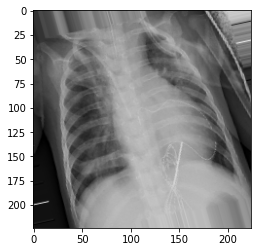

In [8]:
x, y = train_generator.next()
for i in range(0, 1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [9]:
input_image = Input((IMG_SIZE, IMG_SIZE, 3))
feature_extractor = DenseNet121(include_top     =   False,
                                weights         =   'imagenet',
                                input_tensor    =   input_image, 
                                input_shape     =   (IMG_SIZE, IMG_SIZE, 3),
                                pooling         =   'avg') 

29089792/29084464 [==============================] - 1s 0us/step


In [10]:
feature_extractor.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# model = tf.keras.models.Sequential(
#     [
#      feature_extractor,
#      tf.keras.layers.Dense(64, activation='relu'),
#      tf.keras.layers.Dropout(0.2),
#      tf.keras.layers.Dense(64, activation='relu'),
#      tf.keras.layers.Dropout(0.2),
#      tf.keras.layers.Dense(num_classes, activation='softmax')
#     ]
# )

In [13]:
FC = feature_extractor.output
FC = Dense(64, activation="relu")(FC)
FC = Dropout(0.2)(FC)
FC = Dense(64, activation="relu")(FC)
FC = Dropout(0.2)(FC)
FC = Dense(num_classes, activation="softmax")(FC)

model = Model(inputs = feature_extractor.input,
              outputs = FC)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [16]:
save_path = "DenseNet_3.h5"
checkpoint = ModelCheckpoint(save_path,
                             monitor        =   'val_accuracy',
                             verbose        =   1,
                             save_best_only =   True,
                             mode           =   'max')
callbacks = [checkpoint]

In [17]:
cw = class_weight.compute_class_weight('balanced',
                                       np.unique(train_generator.classes),
                                       train_generator.classes)
class_weights = {0: cw[0], 1: cw[1]}
print(class_weights) 

{0: 1.9746153846153847, 1: 0.6695357329160146}


In [18]:
model.compile(optimizer =   tf.optimizers.Adam(learning_rate=0.0001),
              loss      =   'categorical_crossentropy',
              metrics   =   ['accuracy'] )

In [19]:
history = model.fit(train_generator,
                    epochs              =   epochs,
                    callbacks           =   [callbacks],
                    validation_data     =   validation_generator,
                    class_weight        =   class_weights,
                    use_multiprocessing =   True,
                    workers             =   4)

Epoch 1/15
321/321 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9264WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_accuracy improved from -inf to 0.90816, saving model to DenseNet_3.h5
321/321 [==============================] - 1017s 3s/step - loss: 0.1955 - accuracy: 0.9264 - val_loss: 0.1910 - val_accuracy: 0.9082
Epoch 2/15
321/321 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9638WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_accuracy improved from 0.90816 to 0.97959, saving model to DenseNet_3.h5
321/321 [==============================] - 109s 340ms/step - loss: 0.0975 - accuracy: 0.9638 - val_loss: 0.0337 - val_accuracy: 0.9796
Epoch 3/15
321/321 [=========

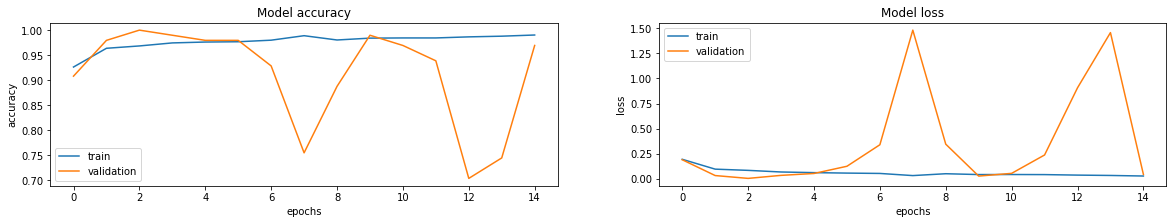

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'validation'])

In [21]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

39/39 [==============================] - 422s 11s/step - loss: 0.2160 - accuracy: 0.9439
Test loss: 0.21601063013076782
Test accuracy: 0.9439102411270142


In [22]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
print('Classification Report:')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.92      0.92       234
   PNEUMONIA       0.95      0.96      0.96       390

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



In [31]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


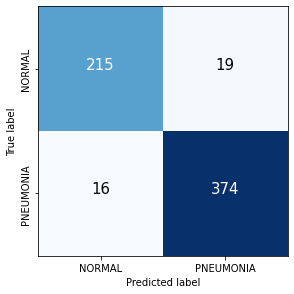

In [26]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [38]:
y_truth = keras.utils.to_categorical(test_generator.classes, 2)

fpr, tpr, threshold = metrics.roc_curve(y_truth[:, 0], Y_pred[:, 0])

AUC = metrics.auc(fpr, tpr)
print('AUC scoer:', AUC)

AUC scoer: 0.9830922638614945


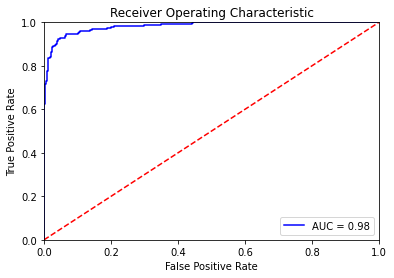

In [39]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()